In [1]:
import os
import tensorflow as tf

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Model training

In [6]:
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

In [13]:
# Just checking if there are any errors in the images dataset

data_dir = 'LionVsTiger' 
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in extension list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('There is some issue with image {}'.format(image_path))

In [14]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 380 files belonging to 2 classes.


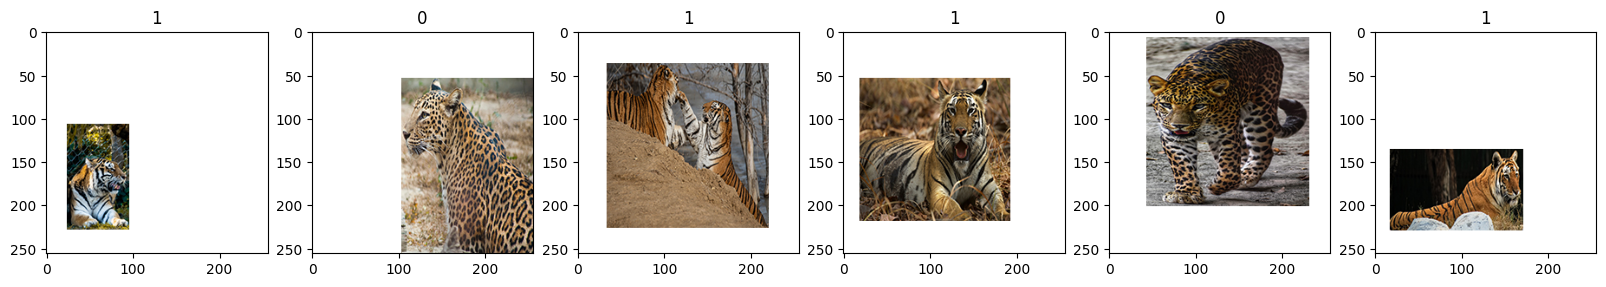

In [15]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [21]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()
data

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [25]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [17]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [18]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


9/9 [==============================] - 34s 248ms/step - loss: 1.4538 - accuracy: 0.4792 - val_loss: 0.6912 - val_accuracy: 0.4844
Epoch 2/20
9/9 [==============================] - 2s 142ms/step - loss: 0.6911 - accuracy: 0.5278 - val_loss: 0.6866 - val_accuracy: 0.6094
Epoch 3/20
9/9 [==============================] - 1s 135ms/step - loss: 0.6830 - accuracy: 0.6250 - val_loss: 0.6674 - val_accuracy: 0.5625
Epoch 4/20
9/9 [==============================] - 1s 145ms/step - loss: 0.6295 - accuracy: 0.6806 - val_loss: 0.6048 - val_accuracy: 0.6562
Epoch 5/20
9/9 [==============================] - 1s 144ms/step - loss: 0.6262 - accuracy: 0.6250 - val_loss: 0.5272 - val_accuracy: 0.8281
Epoch 6/20
9/9 [==============================] - 1s 133ms/step - loss: 0.5637 - accuracy: 0.7153 - val_loss: 0.5102 - val_accuracy: 0.7031
Epoch 7/20
9/9 [==============================] - 1s 127ms/step - loss: 0.4854 - accuracy: 0.7778 - val_loss: 0.5651 - val_accuracy: 0.6875
Epoch 8/20
9/9 [==============

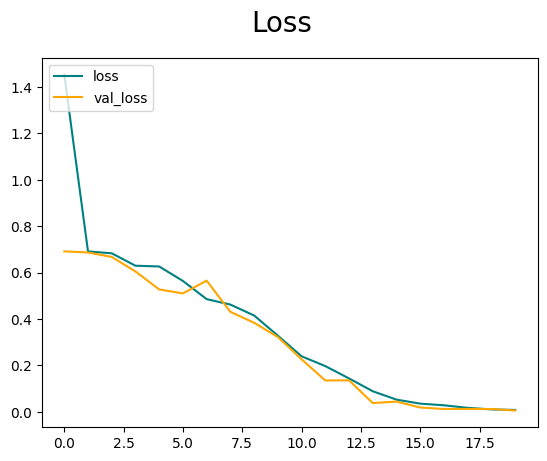

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

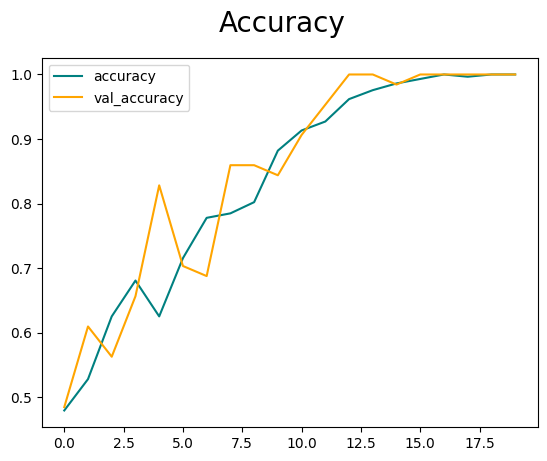

In [20]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [22]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [23]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [24]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


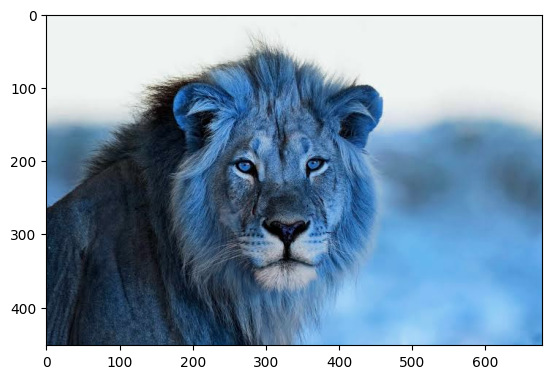

In [38]:
img = cv2.imread('lion.jpeg')
plt.imshow(img)
plt.show()

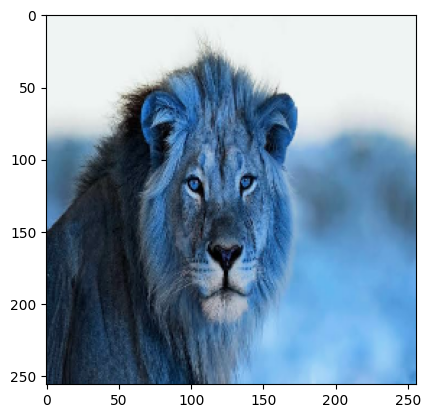

In [39]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [40]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [41]:
if yhat > 0.5: 
    print(f'Predicted class is lion')
else:
    print(f'Predicted class is Tiger')

Predicted class is lion


In [43]:
yhat

array([[0.999471]], dtype=float32)

In [32]:
model.save(os.path.join('models','imageclassifier.h5'))

In [33]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.19388053]], dtype=float32)